# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

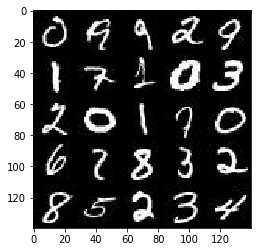

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

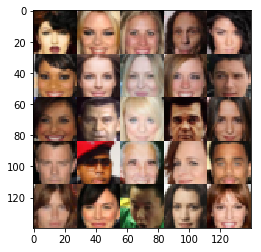

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real') 
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
            
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)


    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # ? not clear
    #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #tf.control_dependencies(update_ops)

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    #g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_shape = data_shape[1:]
        
    input_real, input_z, lr_rate = model_inputs(*image_shape, z_dim)
    
    out_channel_dim = image_shape[-1]
    
    d_loss, g_loss = model_loss(input_real, input_z,out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    n_images = 25
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Sample random noise for G
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr_rate:learning_rate})
                
                # Output losses for every 20 batches
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Output generated images for every 100 batches
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 7.8615
Epoch 1/2... Discriminator Loss: 0.5498... Generator Loss: 2.2752
Epoch 1/2... Discriminator Loss: 0.4258... Generator Loss: 3.7948
Epoch 1/2... Discriminator Loss: 2.6399... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 0.6379... Generator Loss: 3.7419
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 2.1810
Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.9556
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 7.3978
Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 2.4404


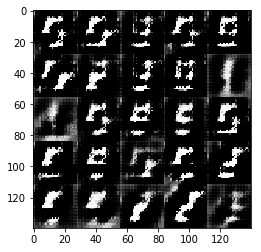

Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 2.3912
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.2855
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 0.6098... Generator Loss: 3.3751
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.7541
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 3.0452
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 2.6064
Epoch 1/2... Discriminator Loss: 2.4816... Generator Loss: 0.2202
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.5019


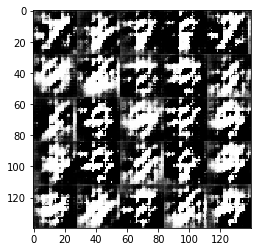

Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 3.6137
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.6421
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.6847
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 2.4711
Epoch 1/2... Discriminator Loss: 3.0915... Generator Loss: 0.1346
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 2.3548
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.2630
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7964


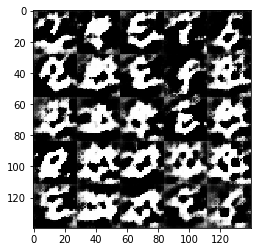

Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 1.2621
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 2.3115
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 2.5871
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 3.1683
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 3.4164
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.0879
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 1.5946
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.9048


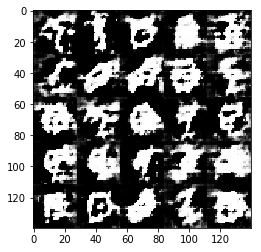

Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.8543
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 1.9519
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.1259
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.3212
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 2.0999
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 2.1194
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 0.8222


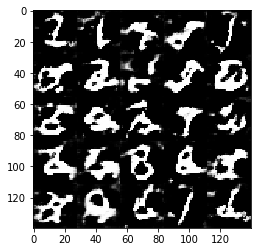

Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 1.3213
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.5667
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 2.0676
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.4621
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.9236


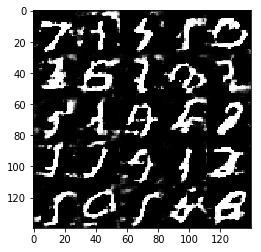

Epoch 1/2... Discriminator Loss: 1.6602... Generator Loss: 2.8817
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.8624
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 2.2112
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 1.6457
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 2.2977
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.6021
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 1.4429
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.5331


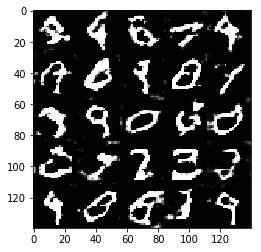

Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 1.1167
Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 1.4177
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.6933
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.3725
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 1.8488
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 2.2181


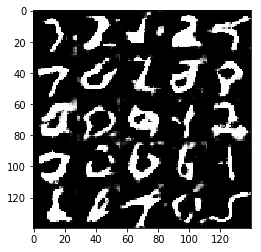

Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.4911
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 1.8297
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 1.5551
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.2998
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 1.6387


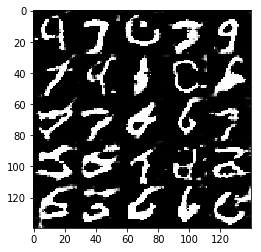

Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.6119... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 1.6417... Generator Loss: 0.4471
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 2.8787... Generator Loss: 4.1879
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 1.0316
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 2.1885


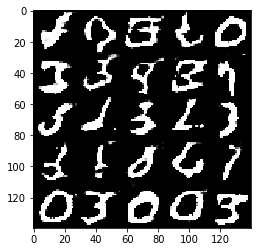

Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 0.5710
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 2.5998... Generator Loss: 3.3775
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.4905
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 1.3265
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.7190... Generator Loss: 0.3936


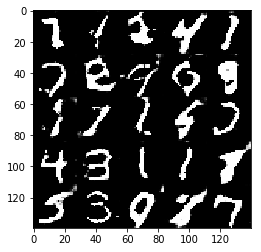

Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 2.5234
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 2.4939
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.4926
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.6541


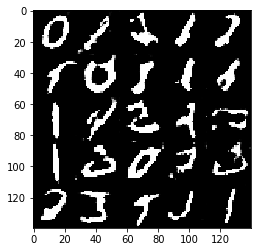

Epoch 2/2... Discriminator Loss: 1.5730... Generator Loss: 0.4381
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.1259
Epoch 2/2... Discriminator Loss: 1.7951... Generator Loss: 0.3379
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.5582
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 2.7588
Epoch 2/2... Discriminator Loss: 0.7510... Generator Loss: 1.7476
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 1.8005
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 1.8586


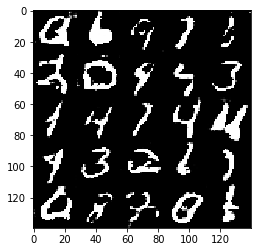

Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 1.8857
Epoch 2/2... Discriminator Loss: 1.2405... Generator Loss: 1.7461
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.6563
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 0.9901
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.3614
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 1.9693


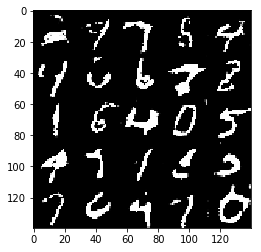

Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.8509... Generator Loss: 3.3718
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 1.1081
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 2.1554


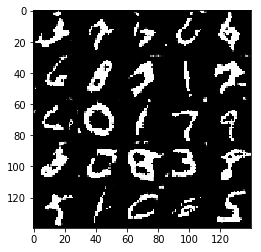

Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 2.0165... Generator Loss: 4.6241
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.4716... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 2.0118
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.8459
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 2.0993
Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.8442


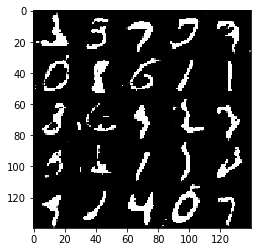

Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 2.8746
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.9536
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 2.1841
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 0.9975
Epoch 2/2... Discriminator Loss: 1.5665... Generator Loss: 0.4965
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 2.1654
Epoch 2/2... Discriminator Loss: 0.8694... Generator Loss: 1.7307
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 2.1518
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.7841


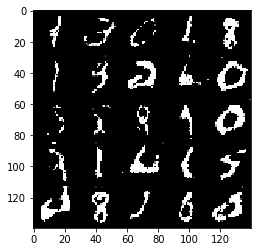

Epoch 2/2... Discriminator Loss: 0.4608... Generator Loss: 2.7322
Epoch 2/2... Discriminator Loss: 1.5456... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 2.4122
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.6693... Generator Loss: 3.5456
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.6077... Generator Loss: 2.3866


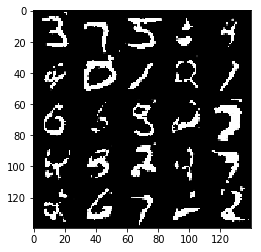

Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.7184
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.6050
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.0247
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.7384
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 2.4273
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.9733


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 9.3062
Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 7.7612
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 3.3554
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 3.9615... Generator Loss: 8.1641
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 3.7842
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.5497
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.9048
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.9497


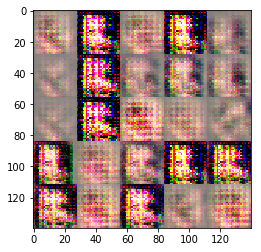

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 2.5781
Epoch 1/1... Discriminator Loss: 1.9090... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 3.4720
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 3.8711
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 2.4230
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 2.1001


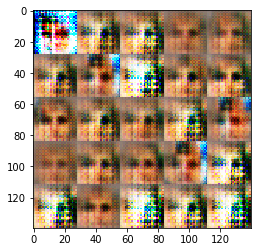

Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 2.0341
Epoch 1/1... Discriminator Loss: 4.5015... Generator Loss: 4.5079
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 1.8741... Generator Loss: 3.3300
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 2.0619


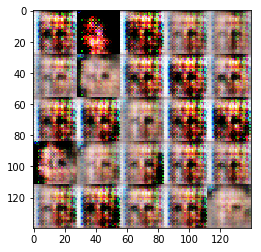

Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 2.3396
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 2.8044
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 3.6543
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 2.0677... Generator Loss: 3.7134
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 3.1438


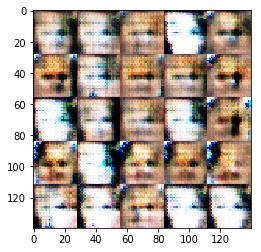

Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.5762
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.9211
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 2.5545
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 1.8941... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8391


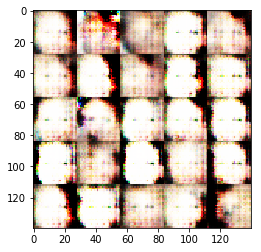

Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 2.1275
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.9214... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.5160
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.1894


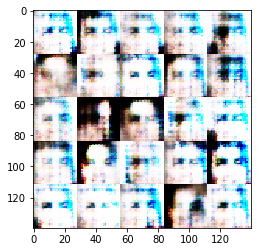

Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 2.4134
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.5628


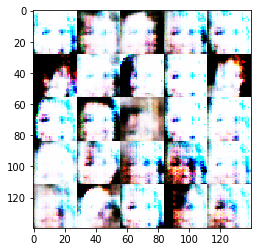

Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 3.0791
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 2.0072
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8157


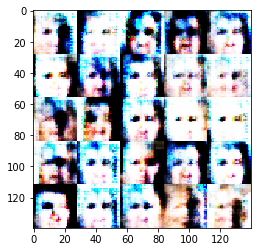

Epoch 1/1... Discriminator Loss: 1.9939... Generator Loss: 2.4199
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.5036
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.8836
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.8933
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 1.8356... Generator Loss: 3.0283


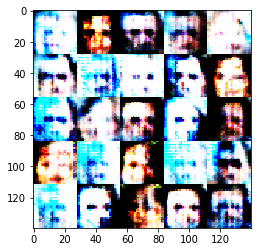

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 2.1896
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.0962


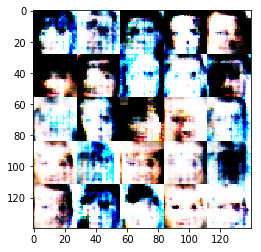

Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.8162
Epoch 1/1... Discriminator Loss: 2.0069... Generator Loss: 0.2856
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 3.3794


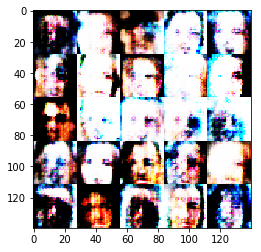

Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 2.2319
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8957


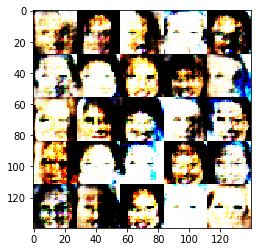

Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.5966
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.5207
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9098


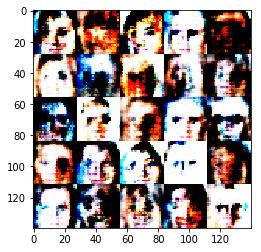

Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.8713... Generator Loss: 0.3127
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 2.0721
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 2.0815
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 2.8061


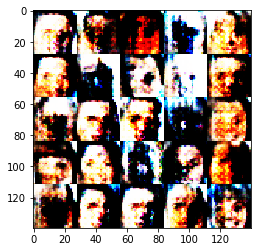

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.8584
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.0362


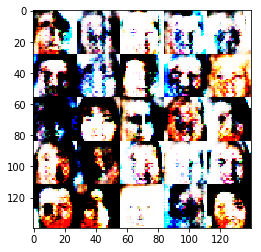

Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.7321


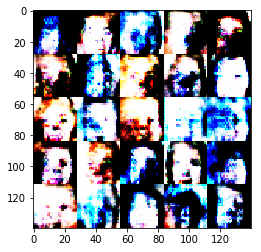

Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 2.0029
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.3485
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.0382


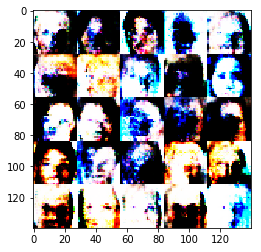

Epoch 1/1... Discriminator Loss: 2.3383... Generator Loss: 2.8047
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.5538


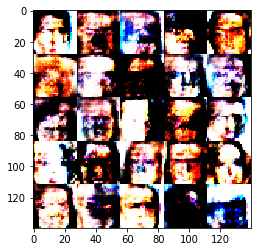

Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 2.3635
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.2324


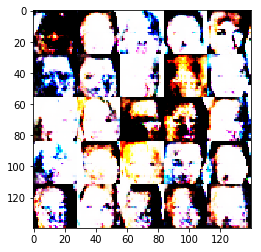

Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.4872


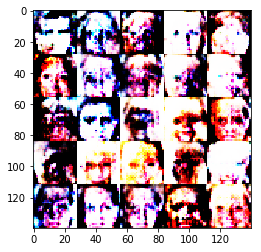

Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.5430
Epoch 1/1... Discriminator Loss: 1.7810... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 1.7835


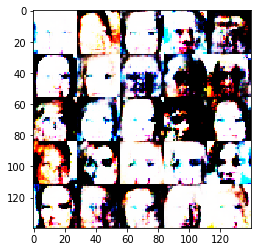

Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 1.7275... Generator Loss: 2.8477
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.0222


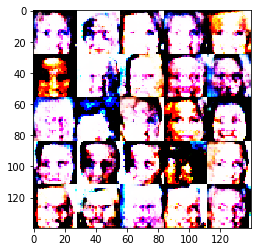

Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.7343


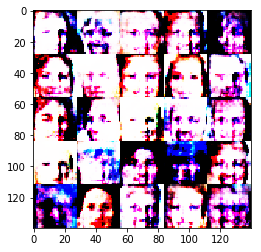

Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 2.2810
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.6325
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.4857


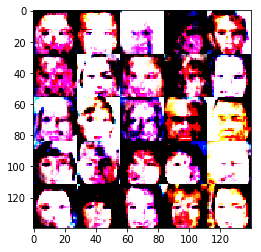

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.6866
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.5408
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.7682


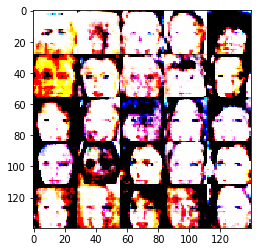

Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 1.5231
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.1366


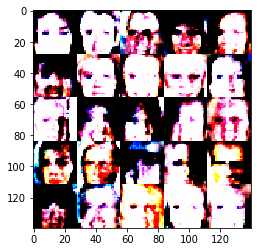

Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.6191
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.2098


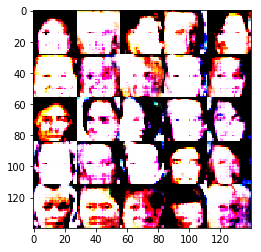

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8985


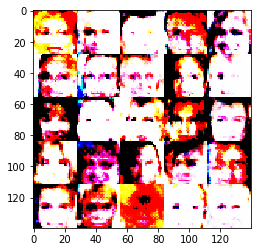

Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 2.0859
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.2219


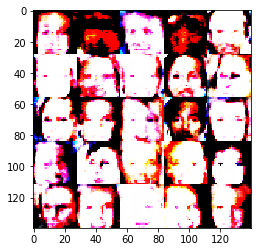

Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.5928
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.9373


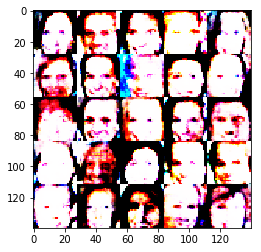

Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.7060
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.4465


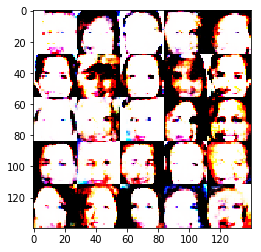

Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 2.0715
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.4610
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7651


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.